In [1]:
import numpy as np
import torch
import cv2 as cv
import glob
import os
import matplotlib.pyplot as plt
from models.model import RoboBlockNet, BlocksDataset
# from google.colab.patches import cv2_imshow

/home/silvery/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


 ```py
 def forward(self, imgs, size=640, augment=False, profile=False): 
     # Inference from various sources. For height=640, width=1280, RGB images example inputs are: 
     #   filename:   imgs = 'data/images/zidane.jpg' 
     #   URI:             = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/zidane.jpg' 
     #   OpenCV:          = cv2.imread('image.jpg')[:,:,::-1]  # HWC BGR to RGB x(640,1280,3) 
     #   PIL:             = Image.open('image.jpg')  # HWC x(640,1280,3) 
     #   numpy:           = np.zeros((640,1280,3))  # HWC 
     #   torch:           = torch.zeros(16,3,320,640)  # BCHW (scaled to size=640, 0-1 values) 
     #   multiple:        = [Image.open('image1.jpg'), Image.open('image2.jpg'), ...]  # list of images 
```

Class for loading labelled data for presentation to the NN

The Neural Network architecture

Test & Train Datasets


In [2]:
img_dir = "data/rgb_new"
depth_dir = "data/depth"
train_labels_dir = "data/segmentations"
test_labels_dir = train_labels_dir#"data/test_segmentation/"
train_dataset = BlocksDataset(img_dir, depth_dir, train_labels_dir)
test_dataset = BlocksDataset(img_dir, depth_dir, test_labels_dir)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)#, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)#, num_workers=4)

Instantiate the model & send to the GPU

In [3]:
device = "cpu"
model = RoboBlockNet()
model = model.to(device)

Perform Training

In [4]:
num_epochs = 100
loss_fn = torch.nn.CrossEntropyLoss(weight = torch.Tensor([1, 250, 250, 250, 250, 250, 250]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for i in range(num_epochs):
  print("epoch {0}".format(i))
  for batch in iter(train_dataloader):
    input_img = batch['rgb_sized'].to(device) # (1, 3, 244, 244)
    output_pred = model(input_img)        # (B, C, H, W) <--> (1, 7, 244, 244) 
    # batch['segmentation_sized'] (1, 1, 244, 244)
    output_gt = batch['segmentation_sized'].squeeze(1).to(device) # (1, 244, 244)
    batch_loss = loss_fn(output_pred, output_gt.to(torch.long))
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(batch_loss.item())

epoch 0


/home/silvery/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1.9511182308197021
epoch 1
1.7633482217788696
epoch 2
1.7921427488327026
epoch 3
1.7452839612960815
epoch 4
1.5898150205612183
epoch 5
1.5026192665100098
epoch 6
1.3731402158737183
epoch 7
1.3316640853881836
epoch 8
1.3191038370132446
epoch 9
1.3303313255310059
epoch 10
1.3610047101974487
epoch 11
1.3491805791854858
epoch 12
1.310568928718567
epoch 13
1.3009511232376099
epoch 14
1.2948130369186401
epoch 15
1.2885535955429077
epoch 16
1.2828357219696045
epoch 17
1.2777180671691895
epoch 18
1.2731058597564697
epoch 19
1.2692561149597168
epoch 20
1.2656234502792358
epoch 21
1.2617515325546265
epoch 22
1.2580444812774658
epoch 23
1.255111813545227
epoch 24
1.2528702020645142
epoch 25
1.2489186525344849
epoch 26
1.2388395071029663
epoch 27
1.221566915512085
epoch 28
1.2230682373046875
epoch 29
1.2190316915512085
epoch 30
1.2161508798599243
epoch 31
1.2145991325378418
epoch 32
1.2123290300369263
epoch 33
1.210383415222168
epoch 34
1.2086950540542603
epoch 35
1.207112193107605
epoch 36
1.2054

Check output against a training dataset ground truth

In [5]:
# model.eval()
# outputs = []
# gts = []
# for batch in iter(train_dataloader):
#   input_img = batch['rgb_sized'].cuda()
#   output_tensor = torch.argmax(model(input_img),1) # model(input_img) (1, 7, 244, 244)
#   outputs.append(output_tensor.squeeze(0)) # output_tensor (1, 244, 244)
#   print(output_tensor.shape)
#   print(batch['segmentation_sized'].shape)
#   # output_tensor.squeeze(0) (244, 244)
#   # batch['segmentation_sized'] (1, 1, 244, 244)
#   gts.append(batch['segmentation_sized'].squeeze().cuda()) # gts[0] (244, 244)

In [6]:
# plt.imshow(outputs[0].cpu().numpy() * 255/6, cmap='gray')
# plt.show()

In [7]:
# test = gts[0].cpu().numpy()
# print(test.shape)
# plt.imshow(gts[0].cpu().numpy() * 255/6, cmap='gray')
# plt.show()

Check Output against a new image (test dataset) ground truth

In [8]:
model.eval()
outputs = []
gts = []
for batch in iter(test_dataloader):
  input_img = batch['rgb_sized'].to(device)
  output_tensor = torch.argmax(model(input_img),1)
  outputs.append(output_tensor.squeeze(0))
  gts.append(batch['segmentation_sized'].squeeze().to(device))

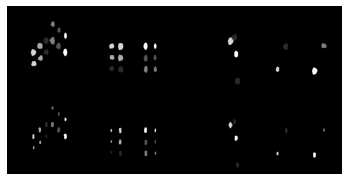

In [9]:
output_pair = np.concatenate([output.cpu().numpy() for output in outputs], axis=1)
gt_pair = np.concatenate([gt.cpu().numpy() for gt in gts], axis=1)
img_pair = np.row_stack((output_pair, gt_pair))
plt.imshow(img_pair * 255/6, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
torch.save(model, "models/model_fcn_re101_cpu.pth")

In [11]:
# plt.imshow(gts[0].cpu().numpy() * 255/6, cmap='gray')
# plt.show()

In [12]:
model_test = torch.load("models/model_fcn_re101_cpu.pth")
model_test.eval()
outputs = []
gts = []
for batch in iter(test_dataloader):
  input_img = batch['rgb_sized'].to(device)
  output_tensor = torch.argmax(model_test(input_img),1)
  outputs.append(output_tensor.squeeze(0))
  gts.append(batch['segmentation_sized'].squeeze().to(device))

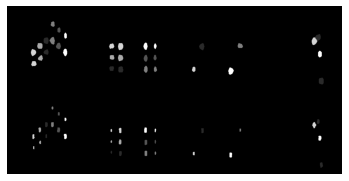

In [13]:
output_pair = np.concatenate([output.cpu().numpy() for output in outputs], axis=1)
gt_pair = np.concatenate([gt.cpu().numpy() for gt in gts], axis=1)
img_pair = np.row_stack((output_pair, gt_pair))
plt.imshow(img_pair * 255/6, cmap='gray')
plt.axis('off')
plt.show()